# PWS Sample Data - Quick Read and Visualize
## Weather Underground Personal Weather Stations (Jan 15-30, 2024)

This notebook demonstrates how to read and visualize the PWS sample dataset in OpenSense-1.0 format.

In [46]:
import netCDF4 as nc
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np


def plot_pws_data(pws_data, start_date, end_date, station_list=None, variable='rainfall_amount'):
    """
    Plot PWS data for selected stations and date range.

    Parameters:
    -----------
    pws_data : dict
        Dictionary of xarray datasets (one per station)
    start_date : str
        Start date in 'YYYY-MM-DD' format
    end_date : str
        End date in 'YYYY-MM-DD' format
    station_list : list or None
        List of station names to plot. If None, plots all stations.
    variable : str
        Variable to plot (default: 'rainfall_amount')
    """

    # If no station list provided, use all stations
    if station_list is None:
        station_list = list(pws_data.keys())

    # Filter to only stations that exist in the data
    available_stations = [s for s in station_list if s in pws_data]

    if len(available_stations) == 0:
        print("⚠ No valid stations found!")
        return

    print(f"Plotting {len(available_stations)} stations from {start_date} to {end_date}")
    print(f"Variable: {variable}")
    print("="*70)

    # Create subplots
    n_stations = len(available_stations)
    n_cols = 2
    n_rows = (n_stations + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4*n_rows))
    if n_stations == 1:
        axes = np.array([axes])
    axes = axes.flatten()

    for idx, station_name in enumerate(available_stations):
        ax = axes[idx]
        station_ds = pws_data[station_name]

        try:
            # Select date range
            station_subset = station_ds.sel(time=slice(start_date, end_date))

            if len(station_subset['time']) == 0:
                ax.text(0.5, 0.5, f'No data in date range',
                       ha='center', va='center', transform=ax.transAxes)
                ax.set_title(station_name, fontsize=10, fontweight='bold')
                continue

            # Plot the variable
            if variable in station_subset.data_vars:
                if variable == 'rainfall_amount':
                    # Plot cumulative for rainfall amount
                    cumsum = station_subset[variable].cumsum(dim='time')
                    cumsum.plot(ax=ax, linewidth=2, color='navy')
                    total = float(station_subset[variable].sum().values)
                    ax.set_ylabel('Accumulated Rainfall (mm)', fontsize=10)
                    ax.set_title(f'{station_name}\nTotal: {total:.1f} mm',
                                fontsize=10, fontweight='bold')
                else:
                    # Plot regular time series for other variables
                    station_subset[variable].plot(ax=ax, linewidth=1.5, color='steelblue')
                    ax.set_ylabel(f"{variable.replace('_', ' ').title()}", fontsize=10)
                    ax.set_title(station_name, fontsize=10, fontweight='bold')

                ax.set_xlabel('Time', fontsize=10)
                ax.grid(True, alpha=0.3)
            else:
                ax.text(0.5, 0.5, f'Variable {variable} not found',
                       ha='center', va='center', transform=ax.transAxes)
                ax.set_title(station_name, fontsize=10, fontweight='bold')

        except Exception as e:
            ax.text(0.5, 0.5, f'Error: {str(e)}',
                   ha='center', va='center', transform=ax.transAxes, fontsize=8)
            ax.set_title(station_name, fontsize=10, fontweight='bold')

    # Hide unused subplots
    for idx in range(n_stations, len(axes)):
        axes[idx].axis('off')

    fig.suptitle(f'PWS {variable.replace("_", " ").title()} ({start_date} to {end_date})',
                 fontsize=14, fontweight='bold', y=1.00)
    plt.tight_layout()
    plt.show()

    print(f"\n✓ Plotted {len(available_stations)} stations")


def read_netcdf_groups_to_xarray_dict(ds):
    """
    Convert open netCDF4 groups to dict of xarray Datasets.
    """
    print(f"\n{'=' * 70}")
    print("CONVERTING NETCDF GROUPS TO XARRAY DICT")
    print(f"{'=' * 70}\n")

    stations = {}

    for station_id in ds.groups.keys():
        try:
            station_ds = xr.open_dataset(ds.filepath(), group=station_id, engine='netcdf4')
            stations[station_id] = station_ds
            print(f"  ✓ {station_id}: {len(station_ds.time)} records")
        except Exception as e:
            print(f"  ❌ {station_id}: {e}")

    print(f"\n✓ Converted {len(stations)} stations")
    print(f"{'=' * 70}\n")

    return stations


def plot_pws_accumulated_rainfall(pws_data, start_date, end_date, station_list=None):
    """
    Plot accumulated rainfall for selected stations and date range.

    Parameters:
    -----------
    pws_data : dict
        Dictionary of xarray datasets (one per station)
    start_date : str
        Start date in 'YYYY-MM-DD' format
    end_date : str
        End date in 'YYYY-MM-DD' format
    station_list : list or None
        List of station names to plot. If None, plots all stations.
    """

    # If no station list provided, use all stations
    if station_list is None:
        station_list = list(pws_data.keys())

    # Filter to only stations that exist in the data
    available_stations = [s for s in station_list if s in pws_data]

    if len(available_stations) == 0:
        print("⚠ No valid stations found!")
        return

    print(f"Plotting accumulated rainfall for {len(available_stations)} stations")
    print(f"Period: {start_date} to {end_date}")
    print("="*70)

    # Create subplots
    n_stations = len(available_stations)
    n_cols = 2
    n_rows = (n_stations + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4*n_rows))
    if n_stations == 1:
        axes = np.array([axes])
    axes = axes.flatten()

    for idx, station_name in enumerate(available_stations):
        ax = axes[idx]
        station_ds = pws_data[station_name]

        try:
            # Select date range
            station_subset = station_ds.sel(time=slice(start_date, end_date))

            if len(station_subset['time']) == 0:
                ax.text(0.5, 0.5, f'No data in date range',
                       ha='center', va='center', transform=ax.transAxes)
                ax.set_title(station_name, fontsize=10, fontweight='bold')
                continue

            # Calculate cumulative rainfall
            if 'rainfall_amount' in station_subset.data_vars:
                cumulative = station_subset['rainfall_amount'].cumsum(dim='time')
                total = float(station_subset['rainfall_amount'].sum().values)

                # Plot
                cumulative.plot(ax=ax, linewidth=2, color='navy')
                ax.set_ylabel('Accumulated Rainfall (mm)', fontsize=10)
                ax.set_xlabel('Time', fontsize=10)
                ax.set_title(f'{station_name}\nTotal: {total:.1f} mm',
                            fontsize=10, fontweight='bold')
                ax.grid(True, alpha=0.3)
            else:
                ax.text(0.5, 0.5, f'No rainfall_amount data',
                       ha='center', va='center', transform=ax.transAxes)
                ax.set_title(station_name, fontsize=10, fontweight='bold')

        except Exception as e:
            ax.text(0.5, 0.5, f'Error: {str(e)}',
                   ha='center', va='center', transform=ax.transAxes, fontsize=8)
            ax.set_title(station_name, fontsize=10, fontweight='bold')

    # Hide unused subplots
    for idx in range(n_stations, len(axes)):
        axes[idx].axis('off')

    fig.suptitle(f'Accumulated Rainfall ({start_date} to {end_date})',
                 fontsize=14, fontweight='bold', y=1.00)
    plt.tight_layout()
    plt.show()

    print(f"\n✓ Plotted accumulated rainfall for {len(available_stations)} stations")



## Load PWS Data

In [47]:
# Open the sample file
import pandas as pd
ds_pws = nc.Dataset('pws_opensense_sample_jan.nc', 'r')
pws_meta = pd.read_csv('pws_metadata.csv')
# Display global attributes
print("SAMPLE FILE METADATA")
print("="*70)
print(f"Title: {ds_pws.title}")
print(f"Source: {ds_pws.source}")
print(f"Period: {ds_pws.sample_period}")
print(f"Attribution: {ds_pws.attribution}")
print(f"License: {ds_pws.license}")
print(f"\nNote: {ds_pws.sample_note}")
print("="*70)



SAMPLE FILE METADATA
Title: SAMPLE FILE - Personal Weather Station Data (January 15-30, 2024)
Source: Weather Underground Personal Weather Stations (https://www.wunderground.com/)
Period: 2024-01-15 to 2024-01-30
Attribution: Weather Underground community weather station operators are acknowledged for providing the original observations. Data formatted to OpenSense-1.0 standard by Dror Jacoby.
License: Creative Commons Attribution 4.0 International (CC BY 4.0)

Note: This file contains only a limited time period and subset of stations for demonstration purposes. It is NOT the complete dataset.


In [43]:
# Convert to xarray dict
pws_data = read_netcdf_groups_to_xarray_dict(ds_pws)

## Inspect a Single Station

In [44]:
# Get first station as example
station_name = list(pws_data.keys())[0]
station = pws_data[station_name]

print(f"Station: {station_name}")

# Access latitude/longitude - they're scalar variables in PWS data
if 'latitude' in station.variables:
    lat = float(station['latitude'].values)
    lon = float(station['longitude'].values)
    print(f"Location: {lat:.4f}°N, {lon:.4f}°E")

    # Also check for altitude/elevation
    if 'altitude' in station.variables:
        alt = float(station['altitude'].values)
        print(f"Altitude: {alt:.1f} m")
else:
    print("Location: coordinates not found")

print(f"\nVariables:")
for var in station.data_vars:
    print(f"  - {var}")

print(f"\nCoordinates:")
for coord in station.coords:
    print(f"  - {coord}")

print(f"\nDataset structure:")
print(station)

Station: KNYNEWYO1472
Location: coordinates not found

Variables:
  - rainfall_rate
  - rainfall_amount
  - temperature
  - relative_humidity
  - wind_velocity
  - wind_direction
  - air_pressure

Coordinates:
  - time

Dataset structure:
<xarray.Dataset> Size: 282kB
Dimensions:            (time: 4402)
Coordinates:
  * time               (time) datetime64[ns] 35kB 2024-01-15T00:04:00 ... 202...
Data variables:
    rainfall_rate      (time) float64 35kB 0.254 0.254 0.254 ... 0.0 0.0 0.0
    rainfall_amount    (time) float64 35kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    temperature        (time) float64 35kB ...
    relative_humidity  (time) float64 35kB ...
    wind_velocity      (time) float64 35kB ...
    wind_direction     (time) float64 35kB ...
    air_pressure       (time) float64 35kB ...


## Plot Accumulated and Rainfall for All Stations

Plotting 2 stations from 2024-01-20 to 2024-01-25
Variable: rainfall_amount


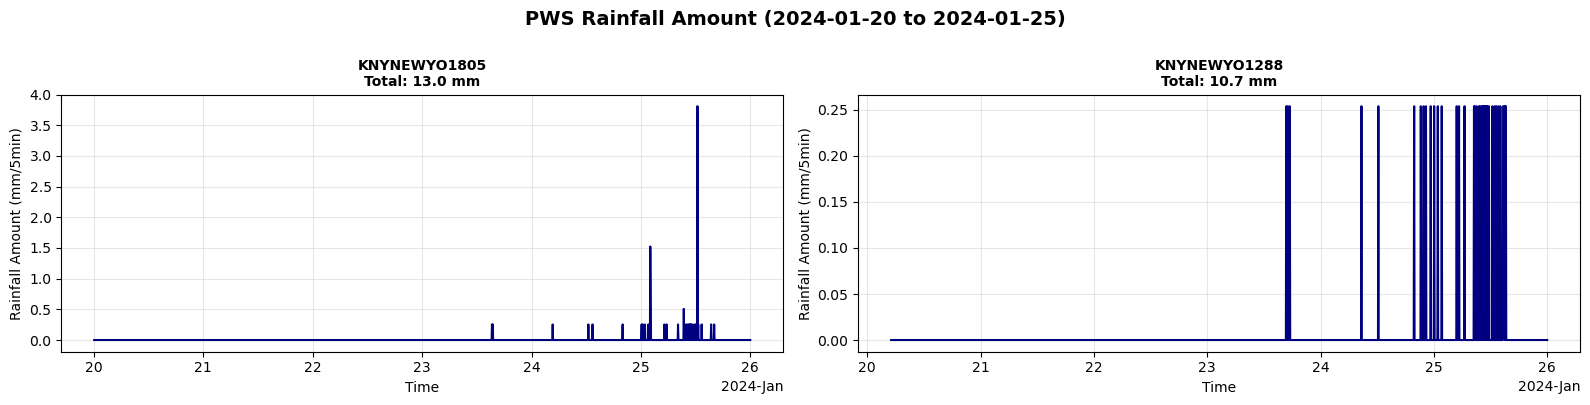


✓ Plotted 2 stations
Plotting 2 stations from 2024-01-15 to 2024-01-30
Variable: temperature


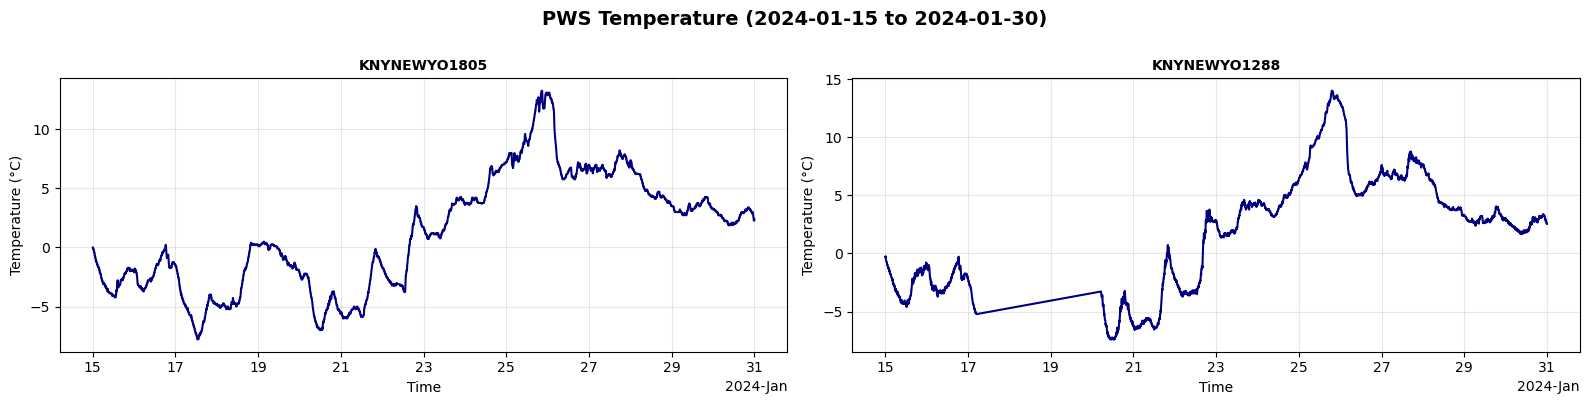


✓ Plotted 2 stations


In [45]:

# Example 2: Plot specific stations only
selected_stations = ['KNYNEWYO1805', 'KNYNEWYO1288']
plot_pws_data(pws_data,
              start_date='2024-01-20',
              end_date='2024-01-25',
              station_list=selected_stations,
              variable='rainfall_amount')

# Example 3: Plot temperature instead
plot_pws_data(pws_data,
              start_date='2024-01-15',
              end_date='2024-01-30',
              station_list=selected_stations,
              variable='temperature')



Plotting accumulated rainfall for 37 stations
Period: 2024-01-15 to 2024-01-30


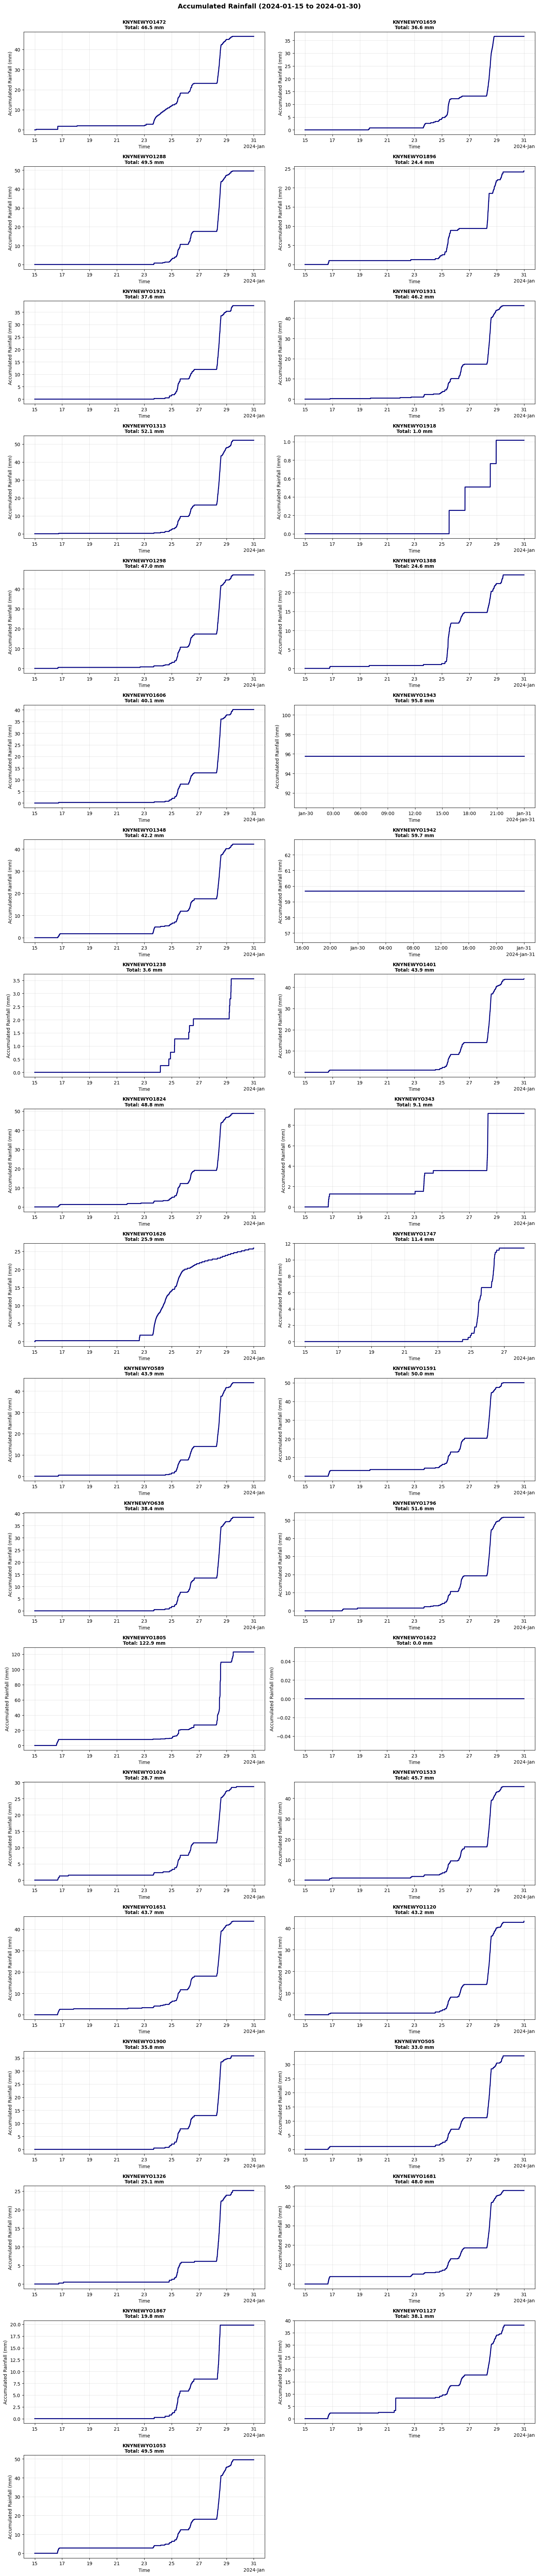


✓ Plotted accumulated rainfall for 37 stations


In [36]:

# Usage example:
plot_pws_accumulated_rainfall(pws_data,
                              start_date='2024-01-15',
                              end_date='2024-01-30',
                              station_list=None)  # All stations

## Summary Statistics

In [24]:
print("RAINFALL SUMMARY (Jan 15-30, 2024)")
print("="*70)
print(f"{'Station':<40s} {'Total (mm)':>12s} {'Max Rate (mm/h)':>16s}")
print("-"*70)

for station_name, station_ds in pws_data.items():
    if 'rainfall_amount' in station_ds.data_vars:
        total = float(station_ds['rainfall_amount'].sum().values)
        
        if 'rainfall_rate' in station_ds.data_vars:
            max_rate = float(station_ds['rainfall_rate'].max().values)
            print(f"{station_name:<40s} {total:12.2f} {max_rate:16.2f}")
        else:
            print(f"{station_name:<40s} {total:12.2f} {'N/A':>16s}")

print("="*70)

RAINFALL SUMMARY (Jan 15-30, 2024)
Station                                    Total (mm)  Max Rate (mm/h)
----------------------------------------------------------------------
KNYNEWYO1472                                    46.48             3.81
KNYNEWYO1659                                    36.58             4.83
KNYNEWYO1288                                    49.53             9.65
KNYNEWYO1896                                    24.38             4.32
KNYNEWYO1921                                    37.59             7.11
KNYNEWYO1931                                    46.23             7.62
KNYNEWYO1313                                    52.07             7.87
KNYNEWYO1918                                     1.02             0.51
KNYNEWYO1298                                    46.99             8.89
KNYNEWYO1388                                    24.64             6.10
KNYNEWYO1606                                    40.13             7.87
KNYNEWYO1943                              

## Close Dataset

In [48]:
# Close the netCDF file when done
ds_pws.close()
print("✓ Dataset closed")

✓ Dataset closed
